In [2]:
%cd ..

/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/American_Retail_Sales/notebooks


In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/processed/final_merged_events.csv', low_memory=False)

In [2]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date,units_sold,wm_yr_wk,sell_price,sales,event_name,event_count
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-29,3,11101,2.0,6.0,NoEvent,0.0
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-30,0,11101,2.0,0.0,NoEvent,0.0
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-31,0,11101,2.0,0.0,NoEvent,0.0
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-01,1,11101,2.0,2.0,NoEvent,0.0
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-02,4,11101,2.0,8.0,NoEvent,0.0


In [210]:
import pandas as pd

store_names = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']


# Group by 'date' and sum the 'sales' column for all stores
daily_sales = data.groupby('date')['sales'].sum().reset_index()

daily_sales['date'] = pd.to_datetime(daily_sales['date'])
#daily_sales.set_index('date', inplace=True)
#daily_sales = daily_sales.resample('D').sum()  #


In [165]:
duplicate_dates = daily_sales[daily_sales.duplicated()]
print(duplicate_dates)

Empty DataFrame
Columns: [date, sales]
Index: []


In [126]:
daily_sales.head()

,date,sales
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [211]:
test_data = pd.read_csv('../data/processed/test_final_merged.csv', low_memory=False)


In [212]:
test_daily_sales = test_data.groupby('date')['sales'].sum().reset_index()
test_daily_sales['date'] = pd.to_datetime(test_daily_sales['date'])
#test_daily_sales.set_index('date', inplace=True)
#test_daily_sales = test_daily_sales.resample('D').sum()  #


In [74]:
test_daily_sales.head()

,sales
date,
2015-04-19,141758.65
2015-04-20,105781.23
2015-04-21,96606.05
2015-04-22,95237.65
2015-04-23,96460.08


In [213]:
daily_revenue = pd.concat([daily_sales, test_daily_sales], axis=0)


In [120]:
daily_revenue.head()

,date,sales
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


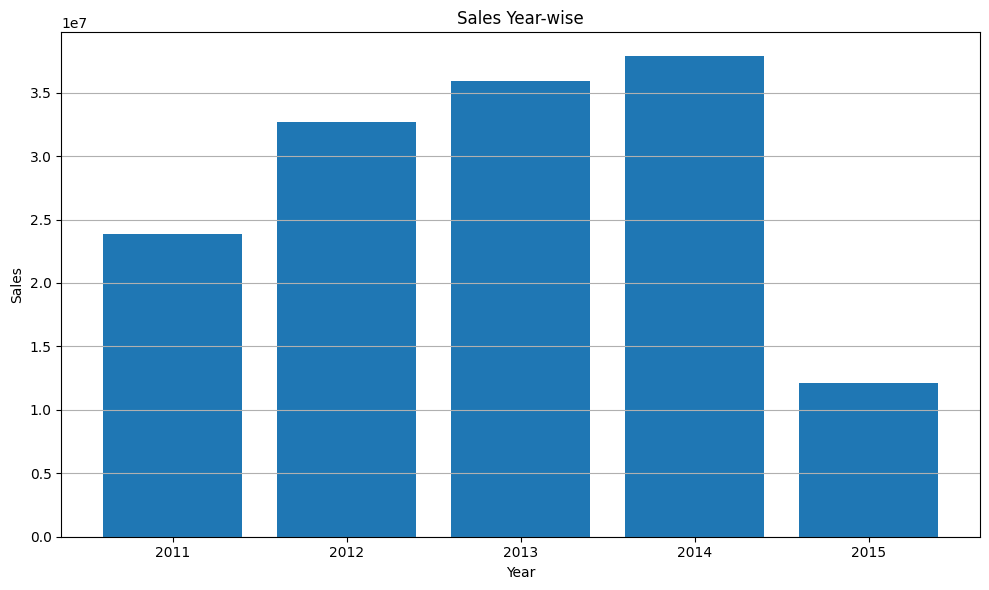

In [7]:
import matplotlib.pyplot as plt

# Assuming you have the 'daily_sales' DataFrame from the previous code

# Extract the year from the 'date' column
daily_sales['year'] = pd.to_datetime(daily_sales['date']).dt.year

# Group by year and sum the sales
yearly_sales = daily_sales.groupby('year')['sales'].sum().reset_index()

# Plotting sales year-wise
plt.figure(figsize=(10, 6))
plt.bar(yearly_sales['year'], yearly_sales['sales'])
plt.title('Sales Year-wise')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(axis='y')
plt.xticks(yearly_sales['year'])
plt.tight_layout()

# Show the plot
plt.show()


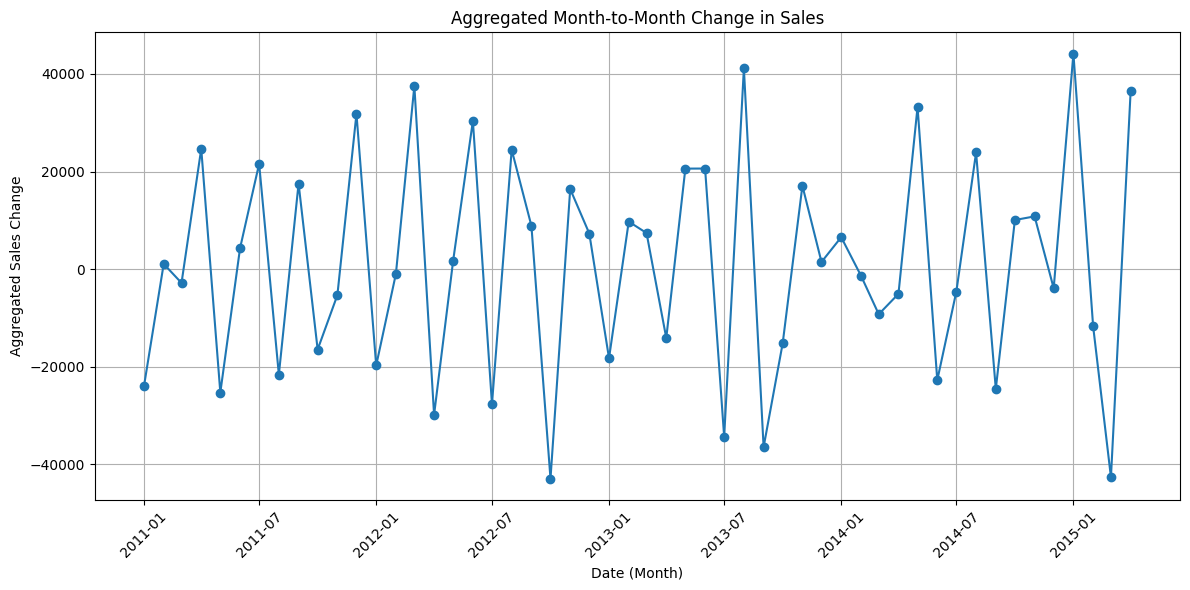

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'daily_sales' DataFrame with 'sales_diff' column from the previous code

# Group by month and sum the month-to-month changes in sales
monthly_sales_diff = daily_sales.groupby(pd.to_datetime(daily_sales['date']).dt.to_period('M'))['sales_diff'].sum()

# Plotting the aggregated month-to-month change in sales as a line graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_diff.index.to_timestamp(), monthly_sales_diff.values, marker='o', linestyle='-')
plt.title('Aggregated Month-to-Month Change in Sales')
plt.xlabel('Date (Month)')
plt.ylabel('Aggregated Sales Change')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [215]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

class ARIMATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, p, d, q):
        self.p = p
        self.d = d
        self.q = q

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Fit ARIMA model and make predictions
        model = ARIMA(X, order=(self.p, self.d, self.q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=7)  # Forecast next 7 days

        return forecast

# Step 4: Split the data into train and test sets
train_size = len(daily_revenue) - 7  # Leave the last 7 days for testing
train_data = daily_revenue[:train_size]
test_data = daily_revenue[train_size:]

# Create and train the pipeline
pipeline = Pipeline([
    ('arima', ARIMATransformer(p=5, d=0, q=5))  # Adjust p, d, and q as (5, 0, 5)
])

pipeline.fit(train_data['sales'])




Pipeline(steps=[('arima', ARIMATransformer(d=0, p=5, q=5))])

In [221]:
# Step 8: Make predictions for the input date
input_date = pd.to_datetime('2016-01-30')  # Replace with your desired input date

# Create a DataFrame up to the input date and feed it to the transform method
historical_data_up_to_input_date = train_data[train_data['date'] <= input_date]
sales_forecast = pipeline.transform(historical_data_up_to_input_date['sales'])

# Print the forecasted sales for the next 7 days
print("Predicted sales for the next 7 days:")
print(sales_forecast)

/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted sales for the next 7 days:
1828    146334.315502
1829    118414.473929
1830    107507.681924
1831    110478.351544
1832    105533.613038
1833    116188.187355
1834    144829.969100
Name: predicted_mean, dtype: float64


/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [217]:
models_dir = "../models/forecasting"  # Update the directory name
os.makedirs(models_dir, exist_ok=True)  # Create the directory if it doesn't exist
model_filename = os.path.join(models_dir, f'arima_pipeline.joblib')

In [218]:
joblib.dump(pipeline, model_filename)


['../models/forecasting/arima_pipeline.joblib']

In [219]:
# Load the saved ARIMA model
models_dir = "../models/forecasting"  # Update the directory name
os.makedirs(models_dir, exist_ok=True)  # Create the directory if it doesn't exist
model_filename = os.path.join(models_dir, f'arima_pipeline.joblib')
loaded_model = joblib.load(model_filename)

In [222]:
# Specify your desired input date
input_date = pd.to_datetime('2016-01-30')

# Create a DataFrame up to the input date
historical_data_up_to_input_date = train_data[train_data['date'] <= input_date]

# Use the loaded pipeline to transform the data
sales_forecast = loaded_model.transform(historical_data_up_to_input_date['sales'])

# Print the forecasted sales for the next 7 days
print("Predicted sales for the next 7 days starting from", input_date)
print(sales_forecast)

/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Predicted sales for the next 7 days starting from 2016-01-30 00:00:00
1828    146334.315502
1829    118414.473929
1830    107507.681924
1831    110478.351544
1832    105533.613038
1833    116188.187355
1834    144829.969100
Name: predicted_mean, dtype: float64


/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tantri/Documents/My Research Material/UTSSpring23/AdvancedML/AT2/Retail_Analytics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
